In [1]:
# Dependencies and plotting style configuration
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import style
plt.style.use('bmh')
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
import matplotlib.colors as colors

#from collections import deque
import pickle
from Utilities.ParticleFilter import *
from Utilities.Dynamics_Constraints_Controller import *
from Utilities.cida import CIDA
from scipy.linalg import sqrtm
import yaml

configuration = yaml.load(open('./configuration.yml', 'r'), Loader=yaml.Loader)

saveFigs = True
FigWidth = 2.5
FigHeight = 2.5
rx = configuration['rx']
T = configuration['T']
num_particles = configuration['num_particles']
Pred_Horizon_N = configuration['Pred_Horizon_N']
number_of_simulations = configuration['number_of_simulations']
LangrangeMultp = configuration['LangrangeMultp']
ru = configuration['ru']
ry = configuration['ry']
V = configuration['V']
tau = configuration['tau']

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/interpolate/_fitpack_impl.py:975: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=21,24 m=400 fp=0.016920 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


CIDA is defined over a particle filter, plus the used controller, prediction horizon and more.

In [2]:
x0 = np.random.randn(rx,1)
x0[0] = 10
x0[2] = -np.pi/2
Cov0 = 0.2 * np.diag(np.ones(rx,))
cida =  CIDA(x0, Cov0, num_particles, stateDynamics, measurementDynamics, Q, R,
                 Pred_Horizon_N, controller, number_of_simulations, CostAndConstraints, LangrangeMultp)
cida.initialize(x0, Cov0)

RandomSearch method returns the desired control input, according to CIDA


In [3]:
cida.RandomSearch()

soft constraints were used.


3.141592653589793

The method sampleAverage returns the current state conditional mean of the particle filter

In [4]:
cida.sampleAverage()

array([[ 9.99703803],
       [-0.45364252],
       [-1.58199477]])

The following function is used to prepare the figure of the orbit and obstacles.

In [5]:
# A function to prepare the figure, its size, and plot the constraints set.

def Constraintsplot(ax):
    xc = np.linspace(-10,10,100)
    yc1 = np.sqrt(10**2-xc**2)
    yc2 = -np.sqrt(10**2-xc**2)
    ax.set_xlabel('$x\,\, (m)$', fontsize=9)
    ax.set_ylabel('$y\,\, (m)$', fontsize=9)
    ax.plot(xc,yc1,'r')
    ax.plot(xc,yc2,'r')
    ax.axis('equal')
    circle1 = plt.Circle((xs[0], ys[0]), rs[0], facecolor = 'blue')
    circle2 = plt.Circle((xs[1], ys[1]), rs[1], color='blue')
    circle3 = plt.Circle((xs[2], ys[2]), rs[2], color='blue')
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    ax.add_patch(circle3)
    pass

Next, we apply CIDA in feedback, versus CE control, as described in our paper.

/var/folders/54/w5632h_d2qdffk_vmkbgn34m0000gn/T/ipykernel_11012/1740749899.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


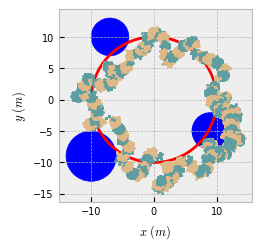

In [29]:
fig, ax= plt.subplots(figsize=(FigWidth,FigHeight))
Constraintsplot(ax)
T = configuration['T']
cida.initialize(x0, Cov0)
x_true = cida.particles[:,random.sample(range(0, cida.num_particles), 1)]
x_true_rec = np.full((rx, T+1), np.zeros)
x_true_rec[:,0] = x_true.squeeze()
AlphaAchieved_CE = np.zeros((T+1,))
#ax.set_xlim((-15,15))
#ax.set_ylim((-15,15))
for k in range(T):
    AlphaAchieved_CE[k] = cida.ViolationProb()
    uSharp = Controller(cida.sampleAverage())
    #print(uSharp, controller(cida.sampleAverage()))
    ax.plot(cida.particles[0,:],cida.particles[1,:],'o', markersize=1.1,color=list(colors.cnames)[k%2+12], zorder=2)
    y = measurementDynamics(x_true, uSharp) + sqrtm(R).real @ np.random.randn(ry, 1)
    cida.Apply_PF(uSharp, y)
    x_true = stateDynamics(x_true, uSharp, sqrtm(Q).real @ np.random.randn(rx,))
    x_true_rec[:,k+1] = x_true.squeeze()
fig.savefig('Figures/CBF_and_CE.png',dpi=400, bbox_inches ="tight")

AlphaAchieved_CE[T]=cida.ViolationProb()   
x_true_rec_CE = x_true_rec
fig.show()




In [30]:
np.save('Data/SavedTrajCE', x_true_rec_CE)

In [24]:

for k in range(0,T):
    print(k)
    AlphaAchieved_cida[k] = cida.ViolationProb()
    uSharp = cida.RandomSearch()
    ax.plot(cida.particles[0,:],cida.particles[1,:],'o', markersize=1.1,color=list(colors.cnames)[k%2 +30], zorder=2)
    y = measurementDynamics(x_true, uSharp) + sqrtm(R).real @ np.random.randn(ry, 1)
    cida.Apply_PF(uSharp, y)
    x_true = stateDynamics(x_true, uSharp, sqrtm(Q).real @ np.random.randn(rx,))
    x_true_rec[:,k+1] = x_true.squeeze()
plt.savefig('Figures/CBF_and_CIDAR.png', dpi=400, bbox_inches ="tight")

AlphaAchieved_cida[T]=cida.ViolationProb()   
x_true_rec_CIDA = x_true_rec
plt.show()




0
1
2
3
4
5
6
7
8
9
10
11
12
soft constraints were used.
13
soft constraints were used.
14
soft constraints were used.
15
16
soft constraints were used.
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
soft constraints were used.
37
soft constraints were used.
38
soft constraints were used.
39
soft constraints were used.
40
soft constraints were used.
41
soft constraints were used.
42
soft constraints were used.
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
soft constraints were used.
75
soft constraints were used.
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
soft constraints were used.
149
soft constraints were used.


<Figure size 640x480 with 0 Axes>

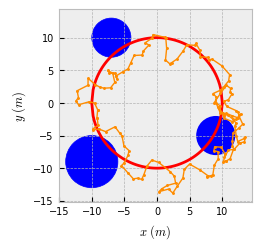

In [31]:

fig, ax= plt.subplots(figsize=(FigWidth,FigHeight))
Constraintsplot(ax)
ax.plot(x_true_rec_CE[0,:],x_true_rec_CE[1,:],'-o', linewidth=1, markersize=1.1,color=list(colors.cnames)[30], zorder=2)
plt.savefig('Figures/CBF_and_CE1.png', dpi=400, bbox_inches ="tight")
plt.show()

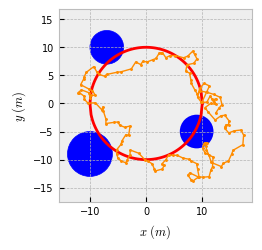

In [25]:

fig, ax= plt.subplots(figsize=(FigWidth,FigHeight))
Constraintsplot(ax)
ax.plot(x_true_rec_CIDA[0,:],x_true_rec_CIDA[1,:],'-o', linewidth=1, markersize=1.1,color=list(colors.cnames)[30], zorder=2)
plt.savefig('Figures/CBF_and_CIDAR1.png', dpi=400, bbox_inches ="tight")
plt.show()

In [13]:
np.save('Data/SavedTrajCIDA', x_true_rec_CIDA)


The following function is used to count the number of violations in each simulation.

In [14]:
def CountViolations(xk2prime):
        xk2prime = np.array(xk2prime, dtype=np.float64)
        d = np.sqrt( xk2prime[0,:] ** 2 + xk2prime[1,:] ** 2)
        gamma = np.arctan2(xk2prime[1,:], xk2prime[0,:])
        theta_d = gamma - np.pi/2 - np.arctan(0.3 * (d-r))
        error = xk2prime[2,:] * 0
        for j in range(len(xk2prime[2,:])):
             error[j] = thetaError(xk2prime[:,j])
        cost = (error ** 2).sum()

        xx = xk2prime[0,:].squeeze()
        yy = xk2prime[1,:].squeeze()
        violation_flag = np.full(error.shape, False)
        for nn in range(3):
            h_value = (xx-xs[nn]) ** 2 + (yy-ys[nn]) ** 2 - rs[nn] ** 2
            violation_flag = violation_flag | (h_value < 0)
        #number_of_violations = (State_violations.squeeze() | Control_violations.squeeze()).sum()
        return violation_flag.sum()

In [32]:
CountViolations(x_true_rec_CE)

8

In [27]:
CountViolations(x_true_rec_CIDA)

3

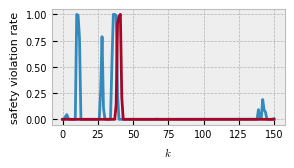

In [33]:
# Generating the violation rates figure
plt.style.use('bmh')
plt.figure(figsize=(3.0,1.5))
plt.plot(AlphaAchieved_CE)
plt.plot(AlphaAchieved_cida)
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels

plt.xlabel('$k$', fontsize=8)  
plt.ylabel('safety violation rate', fontsize=8) 
plt.savefig('Figures/violationRates.png', dpi=400, bbox_inches ="tight")

plt.show()